# <b>Competition context</b>

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## 1. <b>Project Set Up</b>

In [1]:
#Import all the useful librairies for this project
#preprocessing tools
import pandas as pd
import numpy as np

#Visualizing tools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Math tools
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr

In [2]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train_size = train.shape[0]
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
import warnings
warnings.filterwarnings(action="ignore")

## 2. <b>Target Variable Distribution</b>

In every Machine Learning project it's really helpful to analyse your target variable first before starting for real. So let's work a bit on the Saleprice.

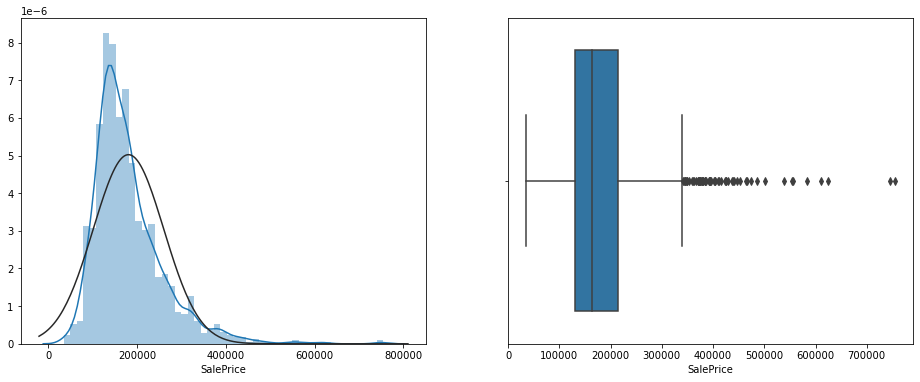

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529
--------------------------------------
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [3]:
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(train['SalePrice'],fit=norm,ax=ax[0])
sns.boxplot(train['SalePrice'])
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(train['SalePrice'].skew()))
print("Kurtosis: {}".format(train['SalePrice'].kurt()))
print("--------------------------------------")
print(train['SalePrice'].describe())

### Conclusion :
* Our distribution is rightly skewed
* The SalePrice is not normally distributed
* The median value (16300 USD) is smaller than the mean value (180921 USD)

![](https://www.safaribooksonline.com/library/view/clojure-for-data/9781784397180/graphics/7180OS_01_180.jpg)

We are in the positive skew case

## 3. <b>Predictors Visualization</b>

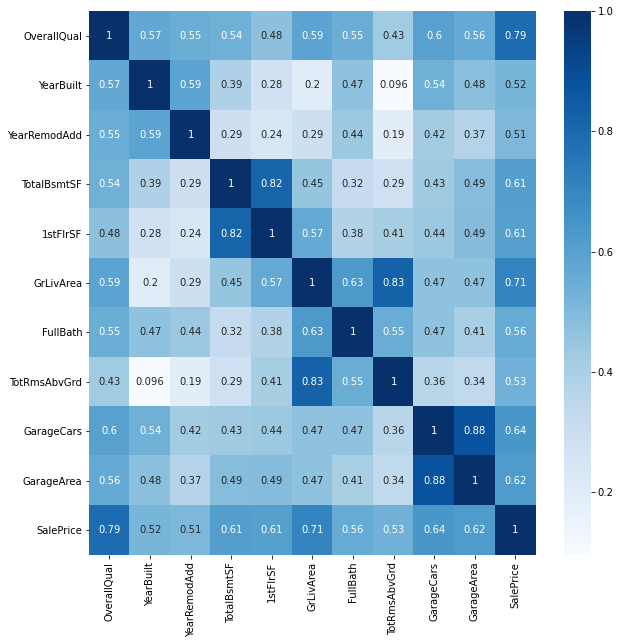

In [4]:
# most correlated features with correlation value > 0.5
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="Blues")

The most correlated predictor with SalePrice is the OverallQual, a value of 0.79

Let's see how each predictors is correlated with **SalePrice**

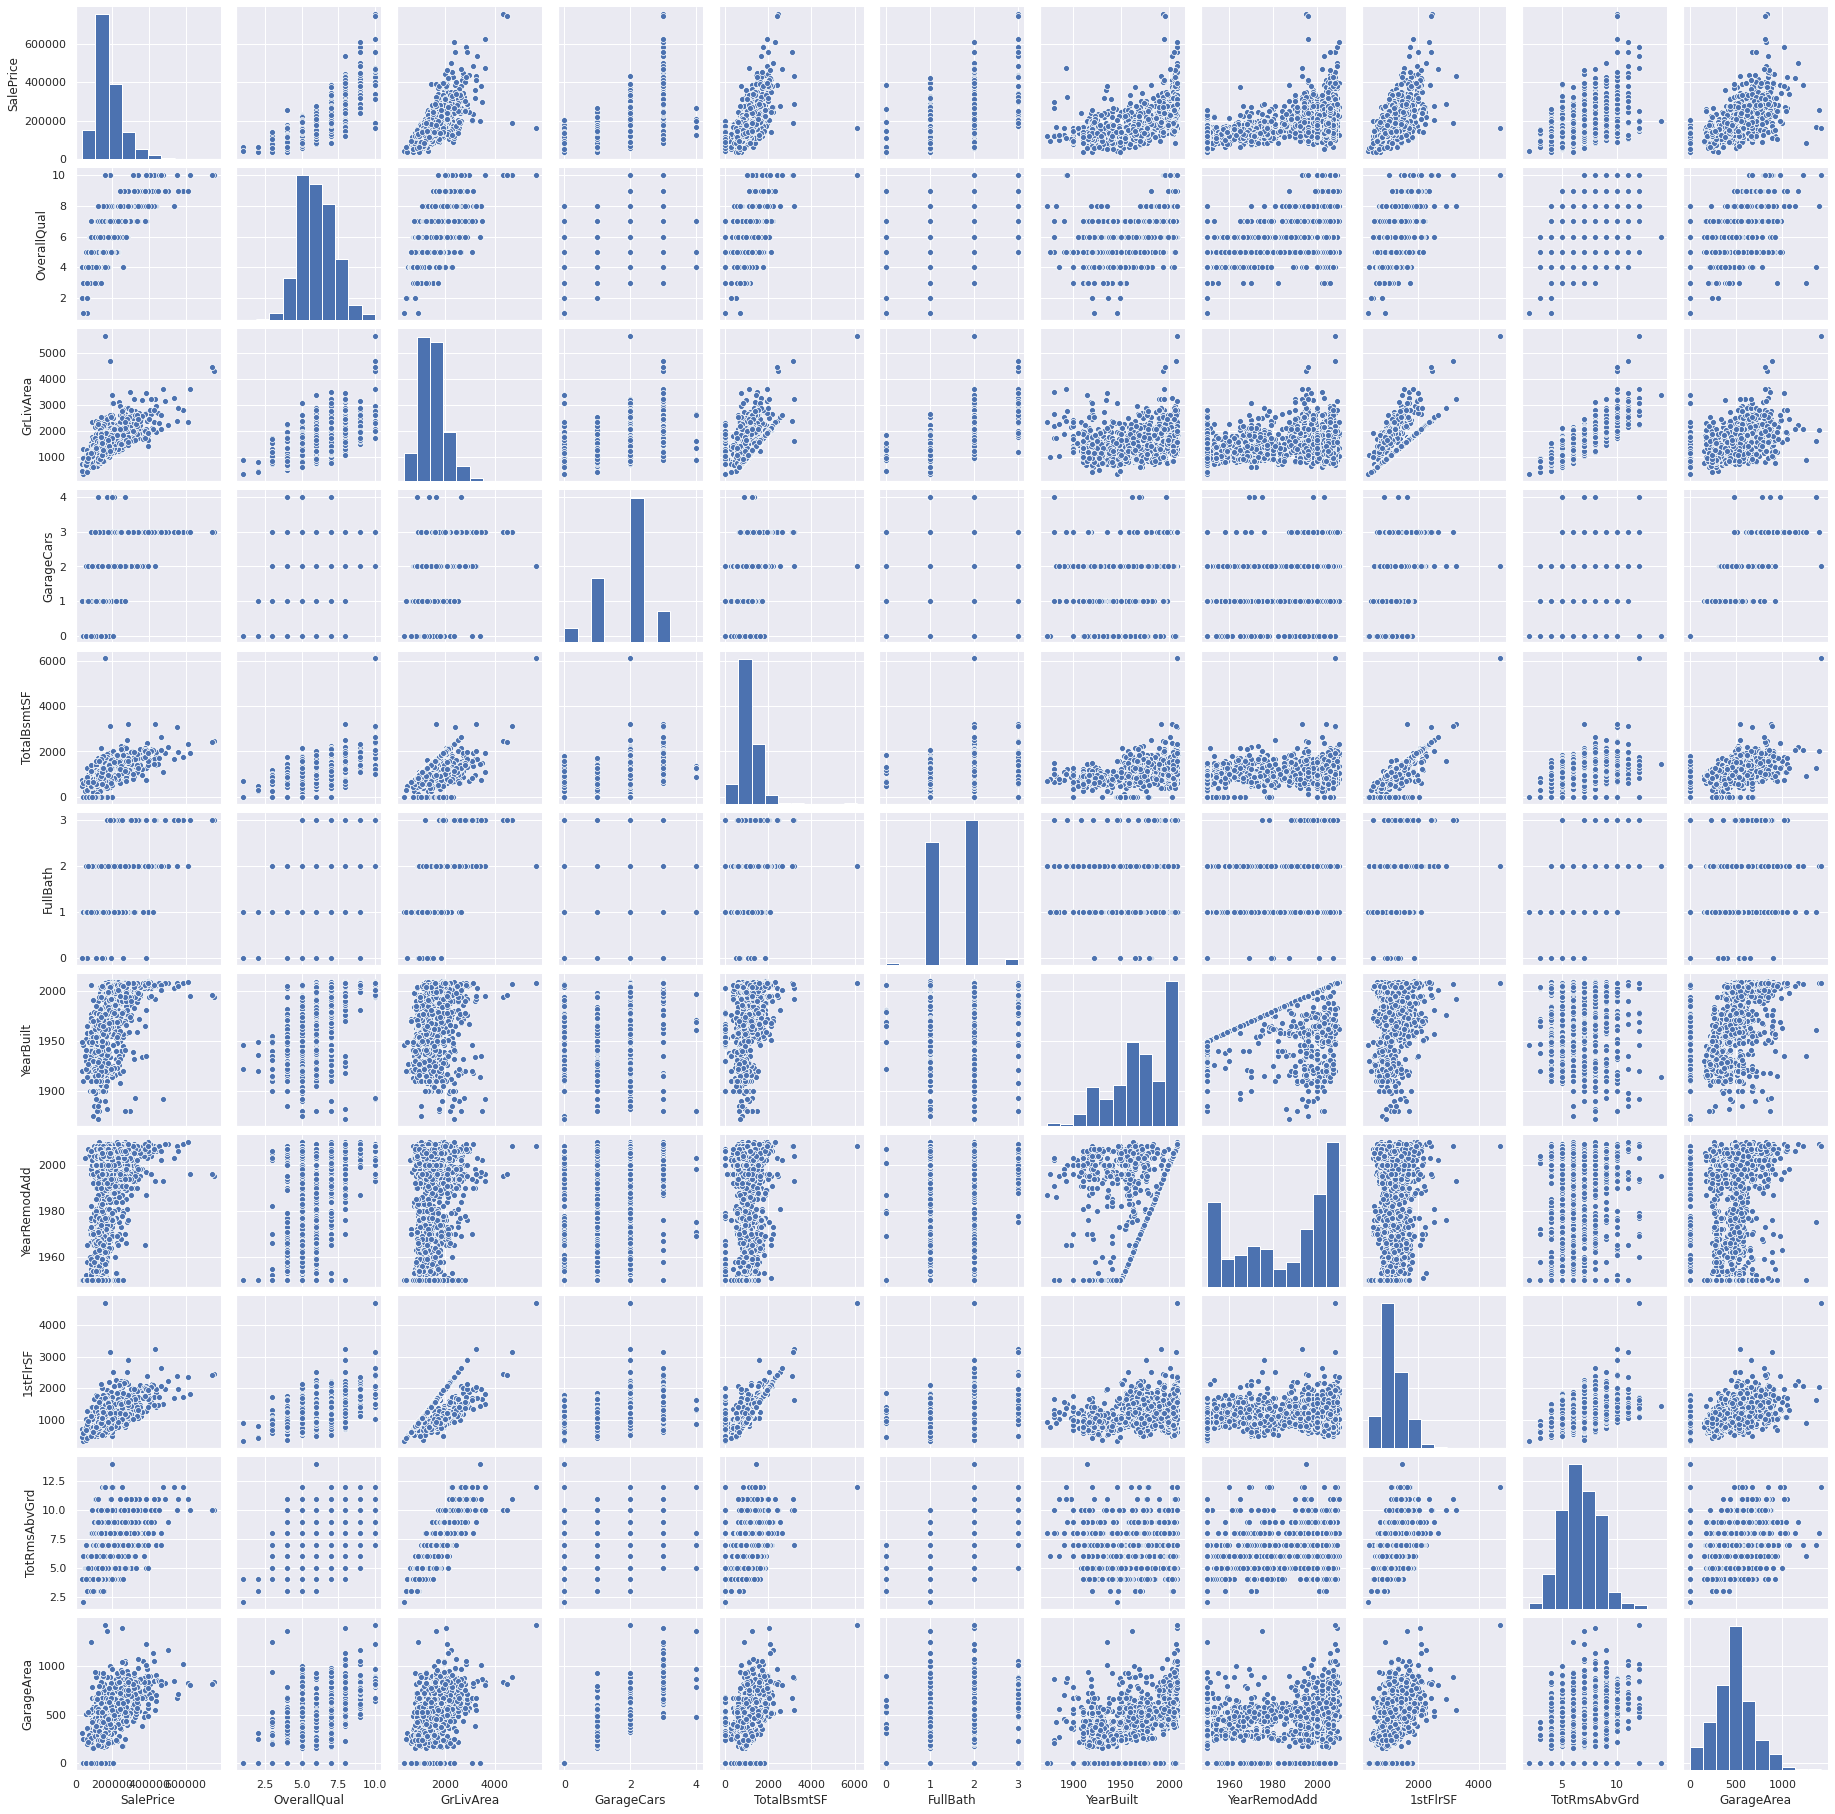

In [5]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea',
        'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd',
        '1stFlrSF','TotRmsAbvGrd','GarageArea']
sns.pairplot(train[cols]).fig.set_size_inches(25,25)
plt.show();

## 4. <b>Data Preprocessing</b>

We need to :
* Reduce the skewness of our features by taking log(features+1)
* Create Dummy variables for the qualitative features
* Replace the NA's values by the mean of theire respective columns

In [6]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
#log transform our target value:
train["SalePrice"] =  np.log1p(train["SalePrice"])

#log transform skewed the numeric features:
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna()))
#compute skewness
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

all_data[skewed_features] = np.log1p(all_data[skewed_features])

#Creation of Dummy Variables
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [7]:
#creating matrices for sklearn:
X_train = all_data[:train_size]
X_test = all_data[train_size:]
y_train = train.SalePrice

## 5. <b>Modeling</b>

In [8]:
#import sklearn tools
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Let's use the ridge regularization for this problem let's also print the cross validation rmse error

In [9]:
alphas = [0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 80]
cv_ridge = [np.sqrt(-cross_val_score(Ridge(alpha = alpha), X_train, y_train, scoring="neg_mean_squared_error", cv = 5)).mean() 
            for alpha in alphas]
best_alpha = alphas[cv_ridge.index(min(cv_ridge))]
cv_ridge = pd.Series(cv_ridge, index = alphas)
min_rmse = cv_ridge.min()
print("best alpha : ", best_alpha, " and minimal rmse : ", min_rmse)

best alpha :  10  and minimal rmse :  0.12733734668670782


So our best ridge model gives us an rmse of 0.12733734668670765 it's quite good

In [10]:
model_Ridge = Ridge(10).fit(X_train, y_train)
ridge_predict = np.exp(model_Ridge.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice": ridge_predict})
percentage_error = mean_absolute_percentage_error(submission.SalePrice, solution.SalePrice)
print(percentage_error)

30.773276470882514


In [11]:
solution.to_csv("ridge_sol.csv", index = False)

I have a mean absolute percentage error of 30.77 % it's pretty high. In my opinion the ridge regularization it's pretty limited.